In [1]:
import torch
import torch.nn as nn

In [2]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016,
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.54MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]


Training:   0%|          | 0/23500 [00:00<?, ?it/s]

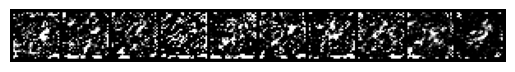

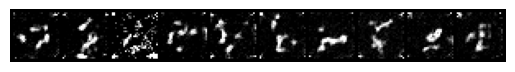

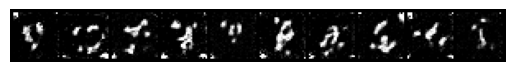

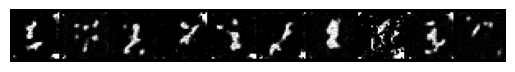

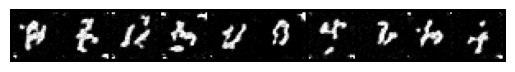

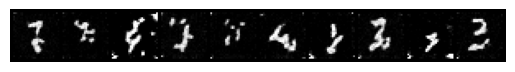

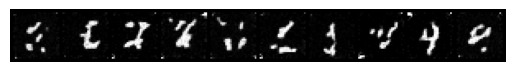

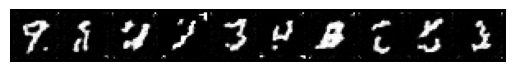

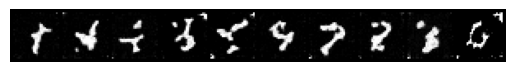

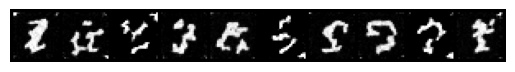

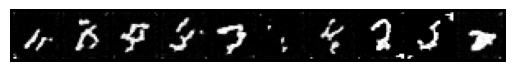

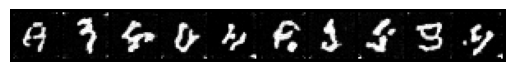

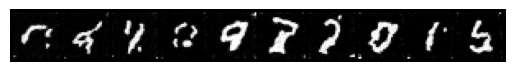

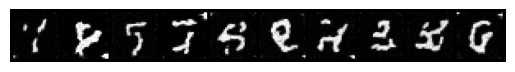

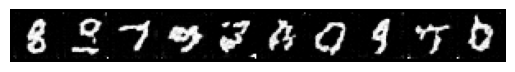

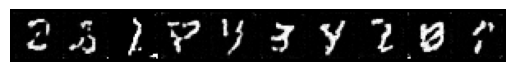

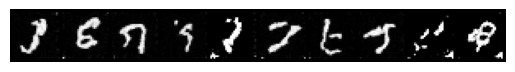

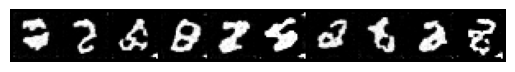

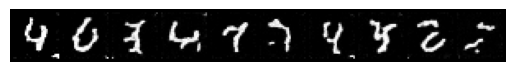

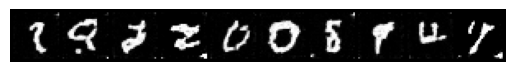

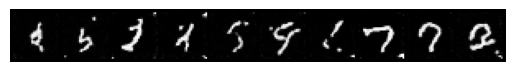

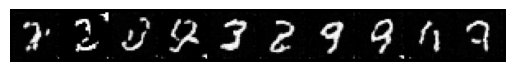

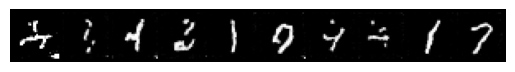

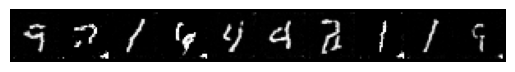

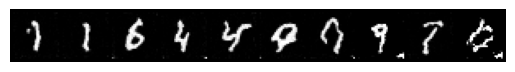

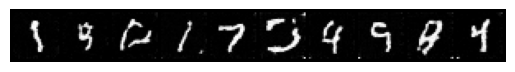

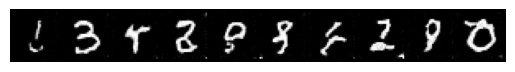

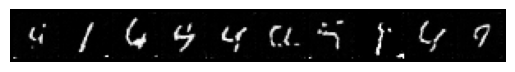

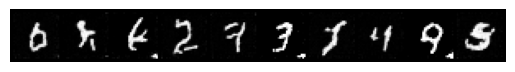

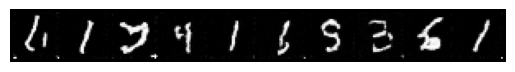

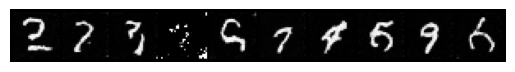

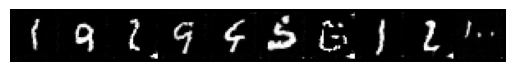

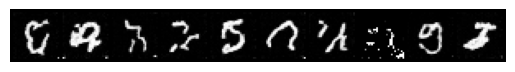

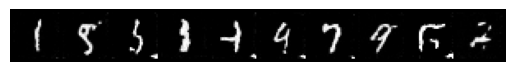

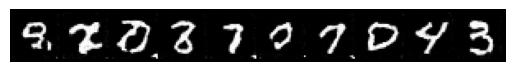

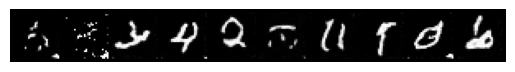

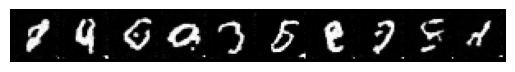

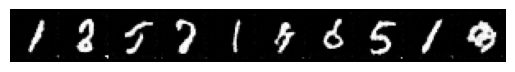

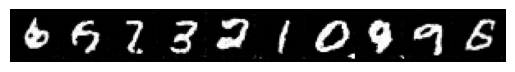

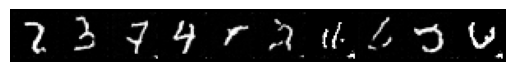

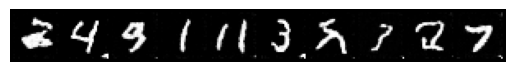

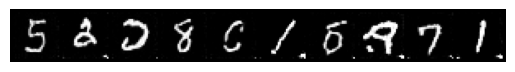

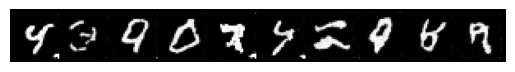

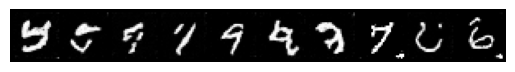

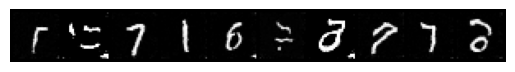

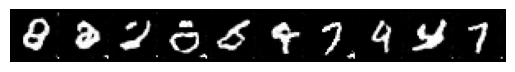

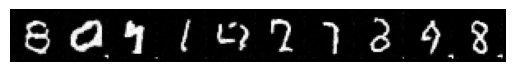

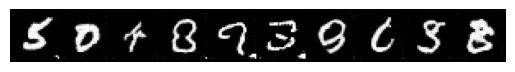

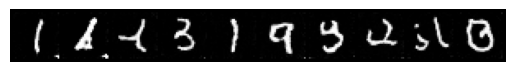

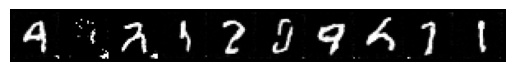

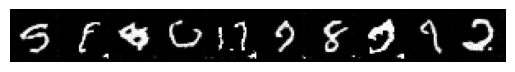

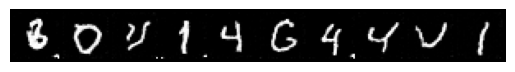

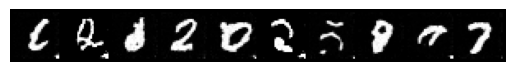

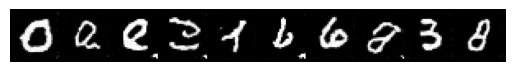

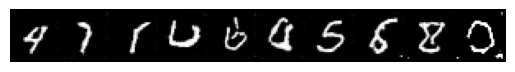

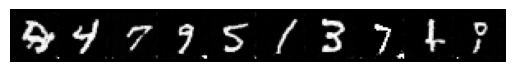

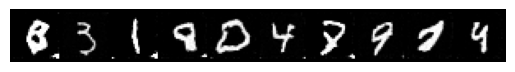

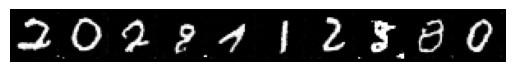

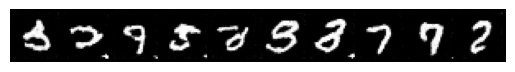

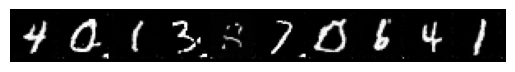

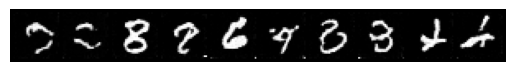

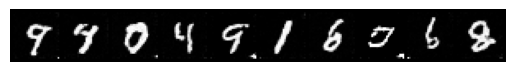

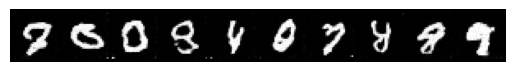

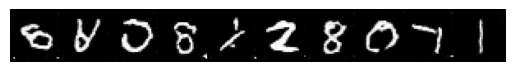

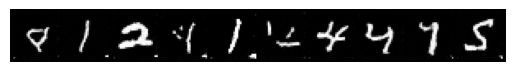

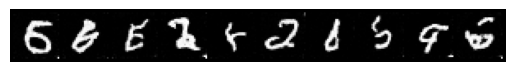

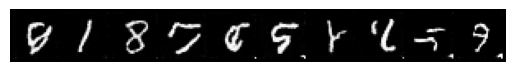

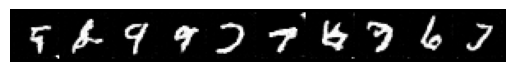

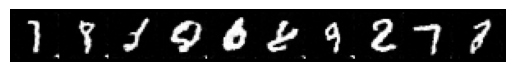

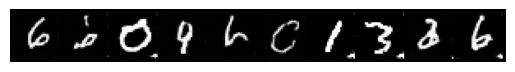

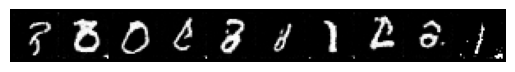

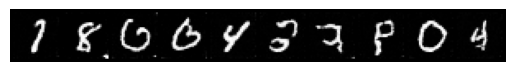

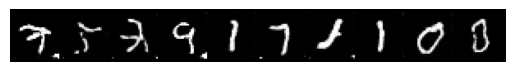

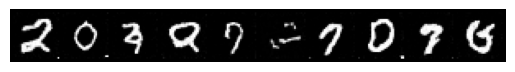

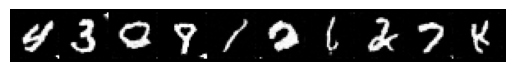

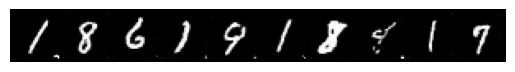

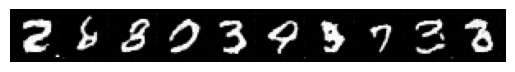

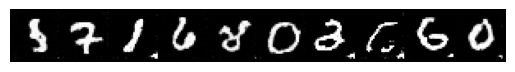

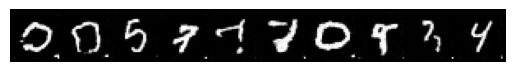

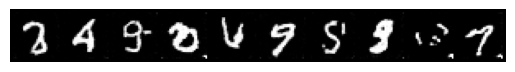

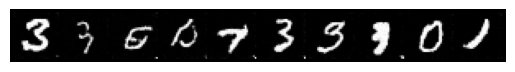

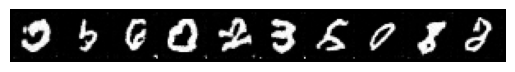

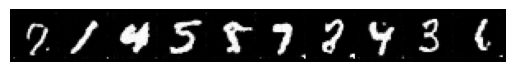

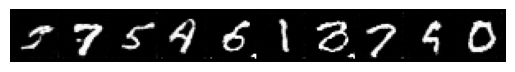

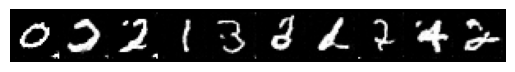

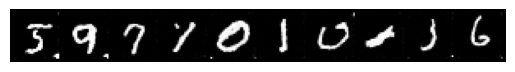

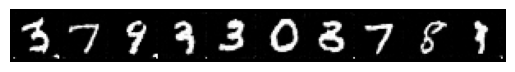

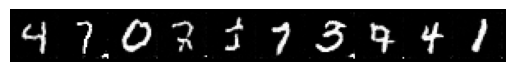

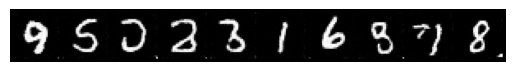

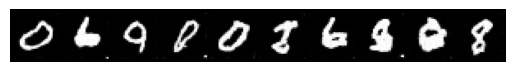

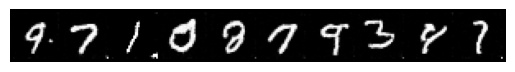

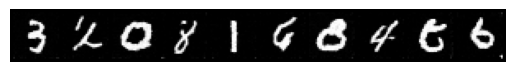

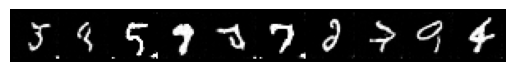

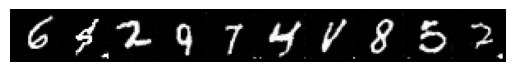

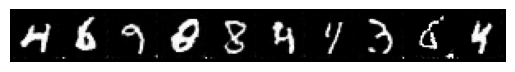

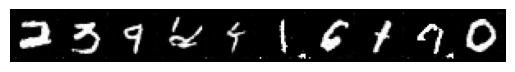

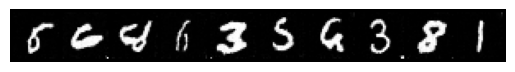

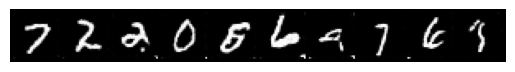

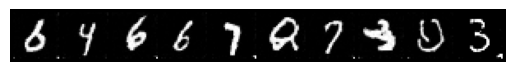

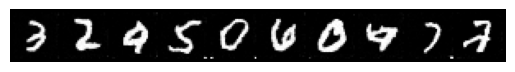

In [4]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """

        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28),
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))


    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon.
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        '''

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])

        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t))
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)

        return mean + std*epsilon


    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image
        """

        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
            xt = self.reverse_diffusion(xt, t, noise)

        return xt


    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)

        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)

        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))


    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop

    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)

    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)

        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()

        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()

# Call training loop
train(model, optimizer, scheduler, dataloader_train,
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

---
# Evaluation Metrics: FID and Inception Score

The following is the newly added evaluation code for calculating FID (Fréchet Inception Distance) and IS (Inception Score).

## FID (Fréchet Inception Distance)
- Compares the distribution of real and generated images
- Lower is better

## Inception Score (IS)
- Measures quality and diversity of generated images
- Higher is better

## Generation Time
- Measures time to generate 100 samples


In [5]:
# Install required packages (if needed)
# !pip install scipy scikit-learn

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
from scipy import linalg
import time
from tqdm.auto import tqdm

class MNISTClassifier(nn.Module):
    """Simple classifier for MNIST (for Inception Score)"""
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def get_features(self, x):
      self.eval() # Force evaluation mode, disable Dropout
      with torch.no_grad(): # No gradient computation, save memory
          x = self.conv1(x)
          x = F.relu(x)
          x = self.conv2(x)
          x = F.relu(x)
          x = F.max_pool2d(x, 2)
          # Do not use dropout when extracting features
          x = torch.flatten(x, 1)
          x = self.fc1(x)
          # Note: Usually take linear output before ReLU, preserving negative values is better for FID
          return x


def train_mnist_classifier(dataloader, epochs=5, device='cuda'):
    """Train MNIST classifier (if no pre-trained model available)"""
    classifier = MNISTClassifier().to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    print("Training MNIST classifier for evaluation...")
    for epoch in range(epochs):
        classifier.train()
        total_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in progress_bar:
            # Convert flattened images back to 28x28
            images = images.reshape(-1, 1, 28, 28).to(device)
            # Convert from [-1, 1] range to [0, 1]
            images = (images + 1) / 2
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix({
                'loss': f'{total_loss/(progress_bar.n+1):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    return classifier


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate Fréchet distance between two Gaussian distributions"""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2

    # Calculate sqrt(sigma1 * sigma2)
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical errors may produce imaginary part
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError(f"Imaginary component {m}")
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


def get_features_from_images(images, classifier, device, batch_size=128):
    """Extract features from images"""
    features = []
    classifier.eval()

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            # Ensure images are in [0, 1] range
            batch = batch.clamp(0, 1)
            # Convert to (N, 1, 28, 28) format
            if batch.dim() == 2:
                batch = batch.reshape(-1, 1, 28, 28)
            feat = classifier.get_features(batch)
            features.append(feat.cpu().numpy())

    return np.concatenate(features, axis=0)


def calculate_fid(real_features, generated_features):
    """Calculate FID (Fréchet Inception Distance)"""
    # Calculate mean and covariance
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID
    fid_value = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid_value


def calculate_inception_score(generated_images, classifier, device, splits=10, batch_size=128):
    """Calculate Inception Score

    IS = exp(E[KL(p(y|x) || p(y))])
    where p(y|x) is the prediction distribution for individual samples, p(y) is the marginal distribution of all predictions
    """
    N = len(generated_images)

    # Get all prediction probabilities
    preds = []
    classifier.eval()

    with torch.no_grad():
        for i in range(0, N, batch_size):
            batch = generated_images[i:i+batch_size].to(device)
            # Ensure images are in [0, 1] range
            batch = batch.clamp(0, 1)
            # Convert to (N, 1, 28, 28) format
            if batch.dim() == 2:
                batch = batch.reshape(-1, 1, 28, 28)

            output = classifier(batch)
            pred = F.softmax(output, dim=1)
            preds.append(pred.cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Split predictions into multiple parts to calculate std
    split_scores = []
    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        # Calculate p(y) - marginal distribution
        py = np.mean(part, axis=0)
        # Calculate KL divergence
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(np.sum(pyx * np.log(pyx / py + 1e-10)))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


def evaluate_model(ddpm_model, classifier, real_dataloader, device,
                  n_samples=10000, batch_size=128):
    """
    Evaluate DDPM model FID and IS

    Parameters
    ----------
    ddpm_model: DDPM model
        Trained DDPM model
    classifier: MNISTClassifier
        Classifier for evaluation
    real_dataloader: DataLoader
        DataLoader for real MNIST data
    device: torch.device
        Device
    n_samples: int
        Number of samples to generate and evaluate
    batch_size: int
        Batch size

    Returns
    -------
    dict: Dictionary containing FID and IS
    """
    print(f"\nEvaluating DDPM model with {n_samples} samples...")

    ddpm_model.eval()

    # 1. Collect real images
    print("Collecting real images...")
    real_images = []
    total_collected = 0  # ✓ New variable

    with torch.no_grad():
        progress_bar = tqdm(real_dataloader, desc="Loading real images")
        for images, _ in progress_bar:
            images = (images + 1) / 2
            real_images.append(images)
            total_collected += images.shape[0]  # ✓ Accumulate actual sample count

            progress_bar.set_postfix({'collected': f'{total_collected}/{n_samples}'})  # ✓ Display progress

            if total_collected >= n_samples:  # ✓ Correct condition
                break

    real_images = torch.cat(real_images, dim=0)[:n_samples]

    # 2. Generate images
    print("Generating images...")
    generated_images = []
    generation_time_100 = 0.0  # Time to generate 100 samples
    n_batches = (n_samples + batch_size - 1) // batch_size

    with torch.no_grad():
        for i in tqdm(range(n_batches), desc="Generating images"):
            current_batch_size = min(batch_size, n_samples - i * batch_size)

            # Measure time for first 100 samples
            if i == 0 and current_batch_size >= 100:
                start_time = time.time()
                samples = ddpm_model.sample((100, 28*28))
                generation_time_100 = time.time() - start_time

                # Convert from [-1, 1] to [0, 1]
                samples = (samples + 1) / 2
                samples = samples.clamp(0, 1)
                generated_images.append(samples.cpu())

                # Generate remaining samples if batch_size > 100
                if current_batch_size > 100:
                    remaining = current_batch_size - 100
                    samples = ddpm_model.sample((remaining, 28*28))
                    samples = (samples + 1) / 2
                    samples = samples.clamp(0, 1)
                    generated_images.append(samples.cpu())
            else:
                samples = ddpm_model.sample((current_batch_size, 28*28))
                # Convert from [-1, 1] to [0, 1]
                samples = (samples + 1) / 2
                samples = samples.clamp(0, 1)
                generated_images.append(samples.cpu())

    generated_images = torch.cat(generated_images, dim=0)

    # 3. Extract features for FID
    print("\nExtracting features for FID...")
    real_features = get_features_from_images(real_images, classifier, device)
    generated_features = get_features_from_images(generated_images, classifier, device)

    # 4. Calculate FID
    print("Calculating FID...")
    fid_score = calculate_fid(real_features, generated_features)

    # 5. Calculate Inception Score
    print("Calculating Inception Score...")
    is_mean, is_std = calculate_inception_score(generated_images, classifier, device)

    results = {
        'FID': fid_score,
        'IS_mean': is_mean,
        'IS_std': is_std,
        'generation_time_100_samples': generation_time_100
    }

    print("\n" + "="*50)
    print("Evaluation Results:")
    print("="*50)
    print(f"FID Score: {fid_score:.4f}")
    print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")
    print(f"Time to generate 100 samples: {generation_time_100:.2f} seconds")
    print("="*50)

    return results

## Usage Example

In [7]:
# 1. Train or load MNIST classifier for evaluation
# Note: For more accurate evaluation, it is recommended to use a pre-trained high-performance classifier
# Here we quickly train a simple classifier as a demonstration

# Prepare dataloader for training classifier (using standard MNIST preprocessing)
classifier_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),  # Dequantize
    transforms.Lambda(lambda x: (x-0.5)*2.0),  # Map to [-1, 1]
    transforms.Lambda(lambda x: x.flatten())  # Flatten for our dataloader format
])

classifier_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', download=True, train=True, transform=classifier_transform),
    batch_size=256,
    shuffle=True
)

# Train classifier（can skip this step，if you have a pre-trained model）
mnist_classifier = train_mnist_classifier(classifier_dataloader, epochs=5, device=device)

Training MNIST classifier for evaluation...


Epoch 1/5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/235 [00:00<?, ?it/s]

In [8]:
# 2. Evaluate trained DDPM model
# Note: Make sure 'model' is your trained DDPM model

evaluation_results = evaluate_model(
    ddpm_model=model,
    classifier=mnist_classifier,
    real_dataloader=dataloader_train,
    device=device,
    n_samples=10000,  # Use 10000 samples for evaluation (can be adjusted)
    batch_size=128
)


Evaluating DDPM model with 10000 samples...


Loading real images:   0%|          | 0/235 [00:00<?, ?it/s]

Generating images...


Generating images:   0%|          | 0/79 [00:00<?, ?it/s]


Extracting features for FID...
Calculating FID...


/tmp/ipython-input-4037139853.py:100: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


Calculating Inception Score...

Evaluation Results:
FID Score: 79.8787
Inception Score: 7.9092 ± 0.0364
Time to generate 100 samples: 2.74 seconds
